In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorboard
import tensorflow as tf
import tensorflow.keras as keras

In [3]:
tf.__version__

'2.14.0'

In [5]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

# Data Processing

In [7]:
source_data_loc = '../../data/bank-churn/Churn_Modelling.csv'

## Read Data

In [8]:
dataset = pd.read_csv(source_data_loc)
dataset.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [9]:
X = dataset.iloc[:,3:-1].values
X

array([[619, 'France', 'Female', ..., 1, 1, 101348.88],
       [608, 'Spain', 'Female', ..., 0, 1, 112542.58],
       [502, 'France', 'Female', ..., 1, 0, 113931.57],
       ...,
       [709, 'France', 'Female', ..., 0, 1, 42085.58],
       [772, 'Germany', 'Male', ..., 1, 0, 92888.52],
       [792, 'France', 'Female', ..., 1, 0, 38190.78]], dtype=object)

In [10]:
y = dataset.iloc[:,-1].values
y

array([1, 0, 1, ..., 1, 1, 0], dtype=int64)

## Train Test Split

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=2024,
    stratify=y
)

In [12]:
len(X_train), len(X_test), len(y_train),len(y_test)

(8000, 2000, 8000, 2000)

## Encoding categorical data

In [13]:
# label encode Gender column

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

X_train[:,2] = label_encoder.fit_transform(X_train[:,2])
print(X_train)


[[571 'France' 0 ... 1 0 102750.7]
 [750 'France' 1 ... 1 1 74564.41]
 [495 'France' 0 ... 1 1 47089.72]
 ...
 [813 'Germany' 1 ... 0 1 85808.22]
 [615 'France' 1 ... 1 1 2755.53]
 [525 'Spain' 1 ... 1 0 161002.29]]


In [14]:
# OHE Geography column

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

ct = ColumnTransformer(
    transformers=[
        ('encoder',OneHotEncoder(),[1])
    ],
    remainder='passthrough'
)
X_train = np.array(ct.fit_transform(X_train))
print(X_train)


[[1.0 0.0 0.0 ... 1 0 102750.7]
 [1.0 0.0 0.0 ... 1 1 74564.41]
 [1.0 0.0 0.0 ... 1 1 47089.72]
 ...
 [0.0 1.0 0.0 ... 0 1 85808.22]
 [1.0 0.0 0.0 ... 1 1 2755.53]
 [0.0 0.0 1.0 ... 1 0 161002.29]]


## Feature Scaling

In [15]:
from sklearn.preprocessing import StandardScaler

standard_scaler = StandardScaler()
X_train = standard_scaler.fit_transform(X_train)

In [16]:
X_test[:,2] = label_encoder.transform(X_test[:,2])
X_test = np.array(ct.transform(X_test))

print(X_test)

[[1.0 0.0 0.0 ... 1 0 27513.47]
 [0.0 0.0 1.0 ... 1 1 179485.96]
 [1.0 0.0 0.0 ... 0 1 61450.96]
 ...
 [0.0 1.0 0.0 ... 0 0 157137.23]
 [1.0 0.0 0.0 ... 0 1 104889.3]
 [0.0 0.0 1.0 ... 1 0 84782.42]]


In [17]:
# Scale X Test

X_test = standard_scaler.transform(X_test)
print(X_test)

[[ 0.99501244 -0.57523331 -0.57561821 ...  0.64550866 -1.03667198
  -1.26731449]
 [-1.00501256 -0.57523331  1.73726261 ...  0.64550866  0.96462528
   1.37782645]
 [ 0.99501244 -0.57523331 -0.57561821 ... -1.54916591  0.96462528
  -0.67661913]
 ...
 [-1.00501256  1.73842505 -0.57561821 ... -1.54916591 -1.03667198
   0.98883801]
 [ 0.99501244 -0.57523331 -0.57561821 ... -1.54916591  0.96462528
   0.07944225]
 [-1.00501256 -0.57523331  1.73726261 ...  0.64550866 -1.03667198
  -0.2705259 ]]


# Building ANN

In [20]:
ann = keras.Sequential(
    [
        keras.layers.Dense(units=32, activation='relu'), # Hidden Layers
        keras.layers.Dense(units=32, activation='relu'), # Hidden layer
        keras.layers.Dense(units=1, activation='sigmoid') # binary classifier needs sigmoid as activation
    ]
)


ann.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
#tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True)

#ann.summary()

In [21]:
# create tensorboard callback
import datetime
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


In [22]:
ann.fit(
    X_train, 
    y_train, 
    batch_size = 32, 
    epochs = 20, 
    validation_data=(X_test, y_test),
    callbacks = [tensorboard_callback]
)

Epoch 1/20
250/250 [==============================] - 1s 3ms/step - loss: 0.5072 - accuracy: 0.7579 - val_loss: 0.4321 - val_accuracy: 0.8150
Epoch 2/20
250/250 [==============================] - 1s 2ms/step - loss: 0.4065 - accuracy: 0.8291 - val_loss: 0.4044 - val_accuracy: 0.8290
Epoch 3/20
250/250 [==============================] - 1s 2ms/step - loss: 0.3778 - accuracy: 0.8465 - val_loss: 0.3827 - val_accuracy: 0.8445
Epoch 4/20
250/250 [==============================] - 1s 2ms/step - loss: 0.3552 - accuracy: 0.8571 - val_loss: 0.3681 - val_accuracy: 0.8480
Epoch 5/20
250/250 [==============================] - 1s 2ms/step - loss: 0.3430 - accuracy: 0.8599 - val_loss: 0.3599 - val_accuracy: 0.8530
Epoch 6/20
250/250 [==============================] - 1s 2ms/step - loss: 0.3369 - accuracy: 0.8644 - val_loss: 0.3614 - val_accuracy: 0.8490
Epoch 7/20
250/250 [==============================] - 1s 2ms/step - loss: 0.3322 - accuracy: 0.8646 - val_loss: 0.3614 - val_accuracy: 0.8520
Epoch 

In [23]:
ann.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                416       
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1505 (5.88 KB)
Trainable params: 1505 (5.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


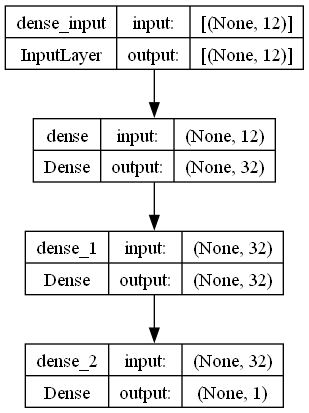

In [24]:
tf.keras.utils.plot_model(ann, to_file='model.png', show_shapes=True)



# Tensorboard UI

In [26]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 25480), started 0:58:27 ago. (Use '!kill 25480' to kill it.)

# Model Evaluation

In [26]:
y_pred_prob = ann.predict(standard_scaler.transform([[1, 0, 0, 600, 1, 40, 3, 60000, 2, 1, 1, 50000]]))
print(y_pred_prob)
print(y_pred_prob > 0.5)

1/1 [==============================] - 0s 52ms/step
[[0.05020798]]
[[False]]


In [36]:
y_pred_prob = ann.predict(X_test)
y_pred = y_pred_prob > 0.5
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

 1/63 [..............................] - ETA: 1s

63/63 [==============================] - 0s 2ms/step
[[0 0]
 [0 1]
 [0 0]
 ...
 [0 0]
 [1 0]
 [0 1]]


## Print Confution Matrix

In [37]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, precision_recall_curve

cm = confusion_matrix(y_test, y_pred)
print(cm)

[[1497   96]
 [ 207  200]]


## Accuracy

In [38]:
accuracy_score(y_pred,y_test)

0.8485

## Precision recall curve

[Text(0.5, 0, 'Precision'),
 Text(0, 0.5, 'Recall'),
 Text(0.5, 1.0, 'Precision Recall Curve')]

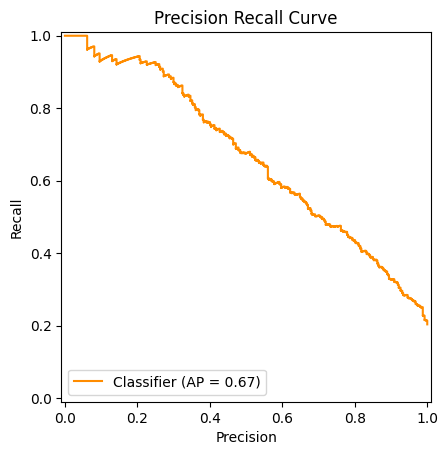

In [43]:
# from sklearn
from sklearn.metrics import PrecisionRecallDisplay

display =  PrecisionRecallDisplay.from_predictions(
    y_pred=y_pred_prob,
    y_true=y_test,
    color='darkorange'
)

display.ax_.set(
    xlabel="Precision",
    ylabel="Recall",
    title="Precision Recall Curve",
)


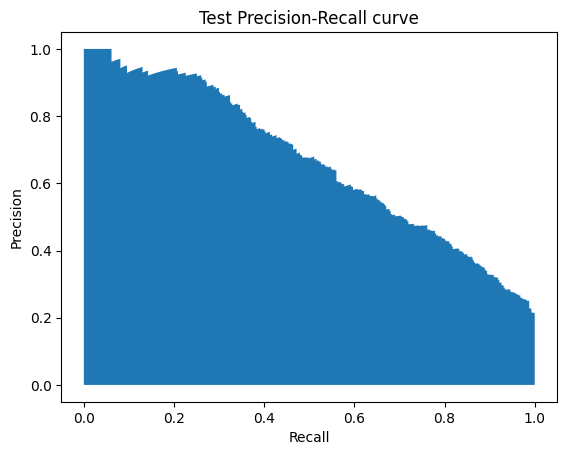

In [40]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
plt.fill_between(recall, precision)
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title("Test Precision-Recall curve");

## ROC Curve

[Text(0.5, 0, 'False Positive Rate'),
 Text(0, 0.5, 'True Positive Rate'),
 Text(0.5, 1.0, 'ROC Curve')]

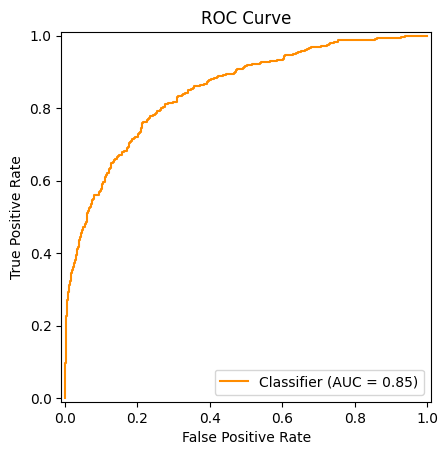

In [41]:
from sklearn.metrics import RocCurveDisplay
display =  RocCurveDisplay.from_predictions(
    y_pred=y_pred_prob,
    y_true=y_test,
    color='darkorange'
)

display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="ROC Curve",
)